# **_Chess Piece Classification_**

### __*This CNN is supposed to determine what kind of Chess Piece is in the Image*__

<br>

### __*Import Libraries and choose the device*__

In [136]:
import csv
# Import of the Libraries
import os
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt

# Torch libraries
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Device config (Pick your set-up)
GPU = torch.device('cpu')  # NVIDIA GPUs
# GPU = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # NVIDIA GPUs
# GPU = torch.device('mps' if torch.has_mps else 'cpu')  # ARM GPUs (M1, M2, ...)
print('Using the Processor') if GPU == torch.device('cpu') else print('Using the Graphics Card')

# Image Dimensions
IMG_SIZE = 85  # 85*85 pixels

Using the Processor


<br>

### __*Create the .csv file for Dataset*__

In [137]:
def create_csv(csv_path, file_path, rewrite=False):
    if not os.path.exists(csv_path) or rewrite:
        file = open(csv_path, 'w', newline='')  # Create the file
        writer = csv.writer(file)               # Create the writer
        categories = os.listdir(FILE_PATH)      # Load all categories
        translate = dict()                      # Class : Number

        # Create a .csv file of all images & their class
        for idx in range(len(categories)):
            translate[idx] = [categories[idx]]
            tmp_path = os.path.join(file_path, categories[idx])
            tmp_images = os.listdir(tmp_path)
            for img in tmp_images:
                img_path = os.path.join(categories[idx], img)  # Sub-File + img
                writer.writerow((img_path, idx))  # Turn category into index

        file.close()                            # Close the file
        return translate

<br>

### __*Convert the Images into a Dataset*__

In [138]:
class ChessDataset(Dataset):

    def __init__(self, csv_path, file_path, transform=None):
        self.annotations = pd.read_csv(csv_path)
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.file_path, self.annotations.iloc[index, 0])
        image = skimage.io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return image, y_label

<br>

### __*Convolutional Neural Network*__

In [139]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input = 3 colour channels, output = 6 (our choice), filter = 4*4 (our choice)
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)  # take 2*2, then move 2 px
        # input = 6 channels, output = 16 (our choice), filter = 4*4 (our choice)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 19 * 19, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # -> n, 3, 85, 85
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 19 * 19)                            # -> n, 400
        x = torch.nn.functional.relu(self.fc1(x))               # -> n, 120
        x = torch.nn.functional.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                                         # -> n, 10
        return x

<br>

### __*Training Preparation*__

Translate: {0: ['pawn'], 1: ['queen'], 2: ['rook'], 3: ['bishop'], 4: ['king'], 5: ['knight']}
N. of images: 516 | Training: 412 | Testing: 104
(tensor([[[0.3961, 0.6706, 0.7451,  ..., 0.7647, 0.7725, 0.7686],
         [0.4000, 0.6627, 0.7451,  ..., 0.7686, 0.7725, 0.7686],
         [0.3882, 0.6667, 0.7451,  ..., 0.7725, 0.7725, 0.7725],
         ...,
         [0.4235, 0.6706, 0.7451,  ..., 0.7647, 0.7569, 0.7569],
         [0.6392, 0.5686, 0.5412,  ..., 0.5255, 0.5333, 0.5255],
         [0.7647, 0.5020, 0.4118,  ..., 0.3882, 0.4039, 0.3961]],

        [[0.3804, 0.6392, 0.7098,  ..., 0.7451, 0.7490, 0.7412],
         [0.3843, 0.6392, 0.7176,  ..., 0.7451, 0.7490, 0.7451],
         [0.3725, 0.6353, 0.7216,  ..., 0.7451, 0.7451, 0.7412],
         ...,
         [0.4078, 0.6392, 0.7098,  ..., 0.7529, 0.7412, 0.7294],
         [0.6196, 0.5451, 0.5176,  ..., 0.5098, 0.5137, 0.5059],
         [0.7412, 0.4824, 0.4000,  ..., 0.3725, 0.3882, 0.3804]],

        [[0.3647, 0.5804, 0.6275,  ..., 0.6

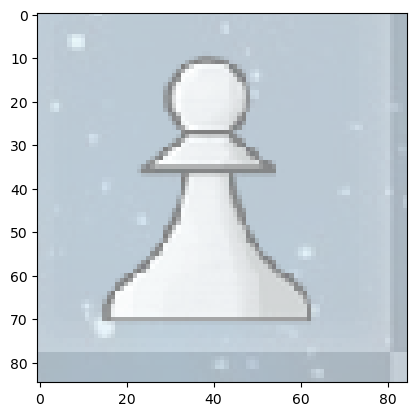

In [140]:
# Define the directory
FILE_PATH = './data/chess/pieces'   # Sub-Folders Location
CSV_PATH = './data/chess/data.csv'  # CSV Location
CATEGORIES = os.listdir(FILE_PATH)  # Turn Sub-Folder names into a list

# Hyper-parameters
num_epochs = 5
batch_size = 1
learning_rate = 0.001

# Create the .csv file & dictionary
indexing = create_csv(CSV_PATH, FILE_PATH, rewrite=True)
print(f'Translate: {indexing}')

# Create the Datasets & DataLoaders
dataset = ChessDataset(CSV_PATH, FILE_PATH, torchvision.transforms.ToTensor())
n_80 = int(len(dataset) / 100 * 80)  # 80% for training
n_20 = int(len(dataset) - n_80)      # 20% for testing
print(f'N. of images: {len(dataset)} | Training: {n_80} | Testing: {n_20}')

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[n_80, n_20])
print(test_dataset[0])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# Create the Model
model = ConvNet().to(GPU)

# Choose type of Loss & Optimization function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


def imshow(img):
    img = img / 2 + 0.5  # un-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images.shape)

# Show images
imshow(torchvision.utils.make_grid(images))

<br>

### __*Training Loop*__

In [144]:
# Variables for
n_total_steps = len(train_loader)
mean_loss = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(GPU)
        labels = labels.to(GPU)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        mean_loss += loss.item()

        # Backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch + 1} / {num_epochs} | Step {i+1} / {n_total_steps} | '
                  f'Loss: {(mean_loss/2000):.4f}')
            mean_loss = 0

print('--- Training Finished ---')
PATH = './chess.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in test_loader:
        images = images.to(GPU)
        labels = labels.to(GPU)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100.0 * n_correct / n_samples
    print(f'Accuracy of the Model: {accuracy} %')

    for i in range(6):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {CATEGORIES[i]}: {accuracy} %')

Epoch 1 / 5 | Step 100 / 412 | Loss: 0.0563
Epoch 1 / 5 | Step 200 / 412 | Loss: 0.0627
Epoch 1 / 5 | Step 300 / 412 | Loss: 0.0675
Epoch 1 / 5 | Step 400 / 412 | Loss: 0.0585
Epoch 2 / 5 | Step 100 / 412 | Loss: 0.0588
Epoch 2 / 5 | Step 200 / 412 | Loss: 0.0624
Epoch 2 / 5 | Step 300 / 412 | Loss: 0.0638
Epoch 2 / 5 | Step 400 / 412 | Loss: 0.0620
Epoch 3 / 5 | Step 100 / 412 | Loss: 0.0565
Epoch 3 / 5 | Step 200 / 412 | Loss: 0.0542
Epoch 3 / 5 | Step 300 / 412 | Loss: 0.0573
Epoch 3 / 5 | Step 400 / 412 | Loss: 0.0528
Epoch 4 / 5 | Step 100 / 412 | Loss: 0.0609
Epoch 4 / 5 | Step 200 / 412 | Loss: 0.0516
Epoch 4 / 5 | Step 300 / 412 | Loss: 0.0498
Epoch 4 / 5 | Step 400 / 412 | Loss: 0.0473
Epoch 5 / 5 | Step 100 / 412 | Loss: 0.0506
Epoch 5 / 5 | Step 200 / 412 | Loss: 0.0403
Epoch 5 / 5 | Step 300 / 412 | Loss: 0.0449
Epoch 5 / 5 | Step 400 / 412 | Loss: 0.0491
--- Training Finished ---
Accuracy of the Model: 65.38461538461539 %
Accuracy of pawn: 100.0 %
Accuracy of queen: 0.0 %
